A Visualization on global temperature data obtained from NASA database

Data source: http://data.giss.nasa.gov/gistemp/

Author: Milad Miladi https://github.com/m-miladi/

In [1]:
#Inputs
glob =  './data/GLB.Ts+dSST.txt'
north = './data/NH.Ts+dSST.txt'
south = './data/SH.Ts+dSST.txt'
zonal = './data/ZonAnn.Ts+dSST.txt'

Method to convert input raw text format into CSV

In [2]:
# Method definition
import re
def input_to_csv(infile_name):
    '''Converts input text file from nasa database into CSV format
        Returns: CSV file name'''
    outfile_name = infile_name.replace(".txt", ".csv")
    with open(infile_name, "r") as infile, open(outfile_name, "w") as outfile:
        prevline = ""
        header_seen = False
        
        # read text line by line
        for line in infile:
#             print "line:", len(line), line.encode('string-escape')
            if line.startswith("Year") :  # If a header line
                if not header_seen:
                    headers = list()
                    for colname in line.split():
                        pos = line.find(colname)
                        
                        # Sometimes there is a word on top of column name that should be prepended
                        if (pos>=0 and len(prevline) >= (pos+1) 
                            and not prevline[pos:pos+len(colname)].isspace()):
                            word_pos=pos
                            # word_pos is starting position of word on top of clumn name
                            while (word_pos-1>=0 and prevline[word_pos-1]!=" "):
                                word_pos-=1
                            colname = (prevline[word_pos:]).split()[0] + colname  # prepend to colname
                        headers.append(colname)
                    
                    # Discard second year column beacuse it is duplicated
                    if headers[-1] == "Year":
                        del(headers[-1])
                        remove_last_col = True

                    outfile.write(",".join(headers)+"\n")

                        
#                 outfile.writeline(line)
                header_seen = True
            elif len(line)>0 and line[0].isdigit():
#                 outfile.write
                line =  re.sub(r'\*+', 'NA', line)  # replace missings with NA
                if remove_last_col is True:
                    outfile.write(",".join(line.split()[0:-1])+"\n")
                else:
                    outfile.write(",".join(line.split())+"\n")
        
            prevline = line
    return outfile_name

Run conversion and aggregate Global, North/South hemisphere with the zonal data

In [3]:
# Convert and filter input files into csv format
import pandas as pd

glob_df  = pd.read_csv(input_to_csv(glob))
north_df = pd.read_csv(input_to_csv(north))
south_df = pd.read_csv(input_to_csv(south))
zonal_df = pd.read_csv(input_to_csv(zonal))
aggregated_df = pd.concat([glob_df[['Year']], glob_df['AnnMeanJ-D']/100.0, north_df['AnnMeanJ-D']/100.0, south_df['AnnMeanJ-D']/100.0, zonal_df.ix[:, 4:]/100.0], axis=1)

# Rename non-zonal columns
colnames = aggregated_df.columns
colnames.values[1:4] = ['Global', 'Northern-Hemisphere', 'Southern-Hemisphere']
aggregated_df.columns = colnames


Plotting using Pandas and Matplotlib

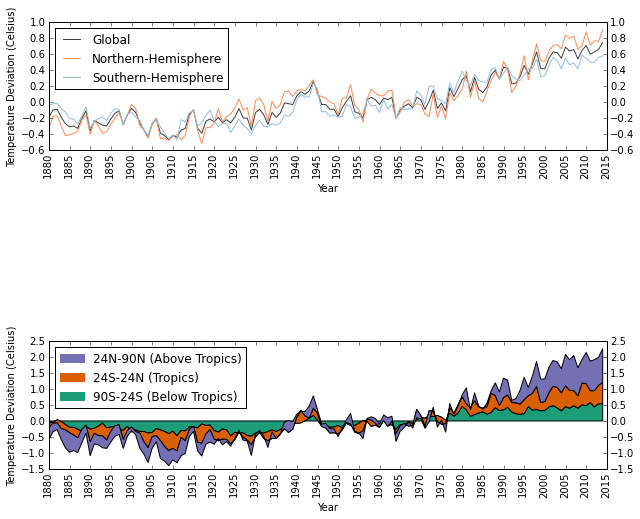

In [5]:
%matplotlib inline
from pylab import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Color palletes
mycolors = ['#1b9e77', '#d95f02', '#7570b3']
mycolors2 = ['#66c2a5', '#fc8d62', '#8da0cb']
mycolors3 = ['#404040', '#fc8d59','#91bfdb']

# Set figure size and hdistance
figure(figsize=(10,8),dpi=200)
subplots_adjust(hspace=1.5)

# First plot as a line plot
ax = subplot(2,1,1)
ax =  pd.concat([aggregated_df['Year'],aggregated_df.ix[:, 1:4]], axis=1).plot(x='Year', color=mycolors3, ax=ax, grid=False)
# Settings for axis & ticks first plot
ax.set_ylabel("Temperature Deviation (Celsius)")
ax.set_xlabel("Year")
ax.set_xlim([1880,2015])
ax.set_xticks(range(1880,2016, 5))
plt.xticks(rotation='vertical')
tick_params(labelright=True)


# Second plot as an stackplot for Zonal data
ax3 = subplot(2,1,2)
three_zone_df = pd.concat([aggregated_df['Year'],(aggregated_df.ix[:, 4:7])], axis=1)
baselines= ['zero', 'sym', 'wiggle', 'weighted_wiggle']
ax3.stackplot(*[aggregated_df[col] for col in ['Year', '90S-24S', '24S-24N', '24N-90N']], baseline='zero',
             colors=mycolors )
# Settings for axis & ticks second plot
ax3.set_ylabel("Temperature Deviation (Celsius)")
ax3.set_xlabel("Year")
ax3.set_xlim([1880,2015])
ax3.set_xticks(range(1880,2016, 5))
plt.xticks(rotation='vertical')
tick_params(labelright=True)

# Matplotlib stackplot does not automatically supports legend, creating the legend manually
ax3.legend([mpatches.Patch(color=c) for c in reversed(mycolors)], 
           ['24N-90N (Above Tropics)', '24S-24N (Tropics)', '90S-24S (Below Tropics)'], loc=2      )
plt.savefig("GW-Figure.png",dpi=300)
plt.show()

